# Generate some random expression data for the tutorial
Dataset with 30 samples and 5 genes

In [1]:
from numpy.random import multivariate_normal, rand, seed
from scipy import random, linalg
import numpy as np

seed(123)

nsamples_LS = 100
nsamples_VS = 50
ngenes = 5

mean = np.zeros(ngenes)

A = rand(ngenes, ngenes)
B = np.dot(A, A.transpose())

dataLS = multivariate_normal(mean, B, size=nsamples_LS)
dataVS = multivariate_normal(mean, B, size=nsamples_VS)

# Network inference with PRS

### Input arguments of `PRS_network`:

**PRS_network**(*dataLS, dataVS, estimator, estimator_kwargs, input_indices=None, normalize_data=True,
                alphas_init=None, lambda_reg=0, nmodels=100, batch_size=None, train_size=None,
                nepochs=3000, learning_rate=0.001, rho1=0.9, rho2=0.999, variance_reduction=True, random_seed=100*)


**dataLS**: Array of shape (n_samples_LS, n_genes). Gene expression, training dataset.

**dataVS**: Array of shape (n_samples_VS, n_genes). Gene expression, validation dataset.

**estimator**: scikit-learn learner class (type of base learner).

**estimator_kwargs**: dictionary containing the hyper-parameters of the estimator. The dictionary does not need to contain all the hyper-parameter values. When a hyper-parameter is missing from the dictionary, it is set to the default value used by scikit-learn.

**input_indices**: indices of the candidate regulators among the genes. If _None_, all the genes are candidate regulators. default=_None_

**normalize_data**: Boolean indicating if data must be normalized. default=_True_

**alphas_init**: Array of shape (n_reg, n_genes), *float* or *None*. Initial values of the feature selection probabilities alphas. n_reg is the number of candidate regulators (= length of input_indices). If *float*, all alphas are initialised at that value. If *None*, all alphas are initialized to 5/nmodels. default=_None_

**lambda_reg**: *float*. Value of the regularisation coefficient for structured sparsity constraint (hyper-parameter *lambda* in the paper). default=0.0

**nmodels**: *int*. Number of base models in each PRS ensemble. default=100

**batch_size**: *int* or *None*. Number of samples in each mini-batch. If *None*, the mini-batch size is set to 10% of the training set size. default=_None_

**train_size**: *int* or *None*.  Number of samples used to train each base model. If *None*, train_size = original training set size - batch_size. default=_None_

**nepochs**: *int*. Number of epochs of the training algorithm. default=3000

**learning_rate**: *float*. Learning rate of the Adam algorithm. default=0.001

**rho1**: *float*. Hyper-parameter rho1 of the Adam algorithm. default=0.9

**rho2**: *float*. Hyper-parameter rho2 of the Adam algorithm. default=0.999

**variance_reduction**: Boolean indicating whether or not to apply the variance reduction technique with baseline. default=_True_

**random_seed**: *int*. Random seed. default=100


### Output of `PRS_network`:
Tuple *(alphas, objective_values_LS, objective_values_VS, error_VS, train_indices)*.

**alphas**: Array of shape (n_reg, n_genes). Trained alphas values. Element [i, j] is the probability of selecting the i-th candidate regulator in the model predicting the j-th gene. 

**objective_values_LS**: Array of shape (nepochs+1,). Values of the objective function at each epoch on the learning set.

**objective_values_VS**: Array of shape (nepochs+1,). Values of the objective function at each epoch on the validation set.

**error_VS**: mean squared error on the validation set

**train_indices**: Indices of the epochs where new models were learned.


In [2]:
from PRS_network import PRS_network

# Base learner = kNN with default hyper-parameters
from sklearn.neighbors import KNeighborsRegressor
estimator = KNeighborsRegressor
estimator_kwargs = dict()

# Note: we use here nepochs=50 to speed up the computation in this tutorial.
# This hyper-parameter should however be set to a higher value in practice.
alphas, objective_values_LS, objective_values_VS, error_VS, train_indices = PRS_network(dataLS, dataVS,
                                                                                        estimator, estimator_kwargs,
                                                                                        nepochs=50)


print('alphas:')
print(alphas)

print('\n')

print('Average subspace size: %.2f' % np.mean(np.sum(alphas, axis=0)))


alphas:
[[0.         0.2872353  0.22302146 0.42556316 0.33350409]
 [0.25842292 0.         0.40030592 0.21928137 0.36918163]
 [0.26394358 0.3818888  0.         0.13731811 0.35242055]
 [0.41350084 0.24756593 0.21919983 0.         0.32547656]
 [0.35407651 0.3840853  0.37147582 0.37942628 0.        ]]


Average subspace size: 1.27


### Plot objective function across iterations

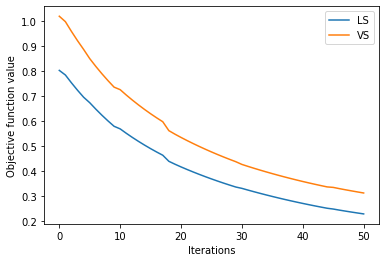

In [3]:
import matplotlib.pyplot as plt

plt.plot(objective_values_LS, label='LS')
plt.plot(objective_values_VS, label='VS')
plt.xlabel('Iterations')
plt.ylabel('Objective function value')
plt.legend()
plt.show()

# Network inference with RaSE

### Input arguments of `rase_network`:

**rase_network**(*dataLS, dataVS, estimator, estimator_kwargs, input_indices=None, normalize_data=True,
                 niterations=10, nmodels=100, B=500, D=None, C0=0.1, random_seed=100, nthreads=1*)


**dataLS**: Array of shape (n_samples_LS, n_genes). Gene expression, training dataset.

**dataVS**: Array of shape (n_samples_VS, n_genes). Gene expression, validation dataset.

**estimator**: scikit-learn learner class (type of base learner).

**estimator_kwargs**: dictionary containing the hyper-parameters of the estimator. The dictionary does not need to contain all the hyper-parameter values. When a hyper-parameter is missing from the dictionary, it is set to the default value used by scikit-learn.

**input_indices**: indices of the candidate regulators among the genes. If _None_, all the genes are candidate regulators. default=_None_

**normalize_data**: Boolean indicating if data must be normalized. default=_True_

**niterations**: *int*. Number of iterations. default=10

**nmodels**: *int*. Number of base models in the ensemble. default=100

**B**: *int*. Number of subspace candidates generated for each base model. default=500

**D**: *int*. Maximal subspace size when generating random subspaces. If None, D is set to min(sqrt(n_samples_LS), nfeatures). default=_None_

**C0**: *float*. Positive constant used to set the minimum feature selection probability. default=0.1

**random_seed**: *int*. Random seed. default=100

**nthreads**: *int*. Number of threads used for parallel computing. default=1


### Output of `rase_network`:
Tuple *(importances, subspace_sizes)*.

**importances**: Array of shape (n_reg, n_genes), where the element [i,j] is the importance of the i-th candidate regulator for the j-th target gene. n_reg is the number of candidate regulators.

**subspace_sizes**: Array of shape (nmodels, n_genes), where the j-th column contains the subspace sizes for the j-th trained ensemble.


In [4]:
from rase_network import rase_network

# Base learner = kNN with default hyper-parameters
from sklearn.neighbors import KNeighborsRegressor
estimator = KNeighborsRegressor
estimator_kwargs = dict()

# The input arguments nmodels and B are set to small values here to speed up the tutorial,
# but should be increased in practice
importances, subspace_sizes = rase_network(dataLS, dataVS, estimator, estimator_kwargs,
                                           normalize_data=True, niterations=3, nmodels=10, B=50)


print('Importances:')
print(importances)

print('\n')

print('Average subspace size: %.2f' % subspace_sizes.mean())

running single threaded jobs
Gene 1/5...
Gene 2/5...
Gene 3/5...
Gene 4/5...
Gene 5/5...
Elapsed time: 66.18 seconds
Importances:
[[0.  0.8 0.  1.  1. ]
 [0.  0.  1.  0.  1. ]
 [0.  0.2 0.  0.1 0. ]
 [1.  0.  0.  0.  0. ]
 [0.5 1.  0.7 0.  0. ]]


Average subspace size: 1.66
